# Technological Factor Analysis: EV Adoption and Charging Infrastructure in Canada  
### Data Cleaning, Processing and Statistical Modeling in Python

In [1]:
import pandas as pd
from IPython.display import display
from functools import reduce
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from scipy.stats import theilslopes
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

## Chapter 1. Data Import and Initial Inspection  
This section loads all raw datasets required for the technological component of the PESTEL analysis.  
The imported files include electric vehicle adoption data, public charging infrastructure data, population series, public transit energy consumption, and national internet usage.  
All datasets will be harmonized later by filtering years, renaming variables and consolidating them into a unified analytical dataset.

In [2]:
# === Chapter 1: Data Import ===
# Load required datasets for the technological factor analysis.
# Comments briefly describe each dataset.

# Display options for more readable outputs
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Load EV data from IEA (contains EV stock share, PHEV share, and charging points)
ev_file = "EVDataExplorer2025_ChargingPorts_International Energy Agency.xlsx"
df_ev_raw = pd.read_excel(ev_file, sheet_name=0)  # Inspect sheet 0 first

# Load population data for density calculations
pop_file = "population.csv"
df_pop_raw = pd.read_csv(pop_file)

# Load public transit bus energy consumption (electricity vs other fuels)
bus_energy_file = "23100084.csv"
df_bus_raw = pd.read_csv(bus_energy_file)

# Load internet usage (context variable)
internet_file = "share-of-individuals-using-the-internet.csv"
df_internet_raw = pd.read_csv(internet_file)

# Quick shape inspection to confirm data loaded correctly
print("EV dataset shape:", df_ev_raw.shape)
print("Population dataset shape:", df_pop_raw.shape)
print("Bus energy dataset shape:", df_bus_raw.shape)
print("Internet usage dataset shape:", df_internet_raw.shape)


EV dataset shape: (16436, 9)
Population dataset shape: (58824, 4)
Bus energy dataset shape: (456, 16)
Internet usage dataset shape: (7151, 4)


In [3]:
# === Chapter 1.1: Initial Data Inspection ===
# Display the first rows of each dataset as proper DataFrames
# This helps verify column names and structure before filtering.

# Inspect EV dataset
display(df_ev_raw.head())

# Inspect Population dataset
display(df_pop_raw.head())

# Inspect Bus energy dataset
display(df_bus_raw.head())

# Inspect Internet usage dataset
display(df_internet_raw.head())


,region_country,category,parameter,mode,powertrain,year,unit,value,Aggregate group
0,World,Projection-STEPS,EV stock,2 and 3 wheelers,BEV,2030,Vehicles,170000000.0,_World
1,World,Projection-STEPS,EV stock,Cars,BEV,2030,Vehicles,150000000.0,_World
2,China,Projection-STEPS,EV stock,2 and 3 wheelers,BEV,2030,Vehicles,91000000.0,Other
3,China,Projection-STEPS,EV stock,Cars,BEV,2030,Vehicles,82000000.0,Other
4,World,Projection-STEPS,EV stock,Cars,PHEV,2030,Vehicles,82000000.0,_World


,Entity,Code,Year,Population (historical)
0,Afghanistan,AFG,-10000,14737
1,Afghanistan,AFG,-9000,20405
2,Afghanistan,AFG,-8000,28253
3,Afghanistan,AFG,-7000,39120
4,Afghanistan,AFG,-6000,54166


,REF_DATE,GEO,DGUID,North American Industry Classification System (NAICS),Fuel consumption,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2005,Canada,2016A000011124,Total bus industries and bus activities in non...,Diesel,Litres,203,thousands,3,v42141347,1.1.1,783760.0,NaN,NaN,NaN,0
1,2005,Canada,2016A000011124,Total bus industries and bus activities in non...,Gasoline,Litres,203,thousands,3,v42141348,1.1.2,10052.0,NaN,NaN,NaN,0
2,2005,Canada,2016A000011124,Total bus industries and bus activities in non...,Other fuels,Litres,203,thousands,3,v42141349,1.1.3,32622.0,NaN,NaN,NaN,0
3,2005,Canada,2016A000011124,Total bus industries and bus activities in non...,Electricity,Kilowatts,200,thousands,3,v42141350,1.1.4,NaN,x,NaN,NaN,0
4,2005,Canada,2016A000011124,Urban transit systems,Diesel,Litres,203,thousands,3,v42141355,1.3.1,409248.0,NaN,NaN,NaN,0


,Entity,Code,Year,Individuals using the Internet (% of population)
0,Afghanistan,AFG,1990,0.0
1,Afghanistan,AFG,1991,0.0
2,Afghanistan,AFG,1992,0.0
3,Afghanistan,AFG,1993,0.0
4,Afghanistan,AFG,1994,0.0


In [4]:
# === Chapter 1.2. Filtering data for Canada and selecting core columns ===
# In this step the raw datasets are filtered to keep only Canadian records and the most relevant variables.  
# The goal is to build cleaner intermediate DataFrames that will later be merged into a unified analytical dataset.

# EV dataset: keep only Canada rows and essential columns
# region_country identifies the geography, parameter defines the metric (stock, share, chargers)
df_ev_ca = df_ev_raw[df_ev_raw["region_country"] == "Canada"].copy()

# Optional: drop obvious projection scenarios if present (e.g., categories containing "Projection")
df_ev_ca = df_ev_ca[~df_ev_ca["category"].str.contains("Projection", case=False, na=False)]

# Keep only key columns for later pivoting
ev_cols = ["year", "parameter", "mode", "powertrain", "unit", "value"]
df_ev_ca = df_ev_ca[ev_cols]

print("EV Canada shape:", df_ev_ca.shape)
display(df_ev_ca.head())


# Population dataset: filter Canada and keep Year + Population
df_pop_ca = df_pop_raw[df_pop_raw["Entity"] == "Canada"].copy()
df_pop_ca = df_pop_ca[["Year", "Population (historical)"]]

# Rename columns to a simple, consistent format
df_pop_ca = df_pop_ca.rename(columns={
    "Year": "year",
    "Population (historical)": "population"
})

print("Population Canada shape:", df_pop_ca.shape)
display(df_pop_ca.head())


# Bus energy dataset: filter Canada (GEO) and keep core columns for later aggregation
df_bus_ca = df_bus_raw[df_bus_raw["GEO"] == "Canada"].copy()

bus_cols = [
    "REF_DATE",              # year
    "North American Industry Classification System (NAICS)",
    "Fuel consumption",
    "VALUE",
    "UOM"
]
df_bus_ca = df_bus_ca[bus_cols]

# Rename REF_DATE to year for consistency
df_bus_ca = df_bus_ca.rename(columns={"REF_DATE": "year"})

print("Bus energy Canada shape:", df_bus_ca.shape)
display(df_bus_ca.head())


# Internet usage dataset: filter Canada and keep Year + Internet usage
df_internet_ca = df_internet_raw[df_internet_raw["Entity"] == "Canada"].copy()
df_internet_ca = df_internet_ca[["Year", "Individuals using the Internet (% of population)"]]

df_internet_ca = df_internet_ca.rename(columns={
    "Year": "year",
    "Individuals using the Internet (% of population)": "internet_usage_pct"
})

print("Internet usage Canada shape:", df_internet_ca.shape)
display(df_internet_ca.head())


EV Canada shape: (339, 6)


,year,parameter,mode,powertrain,unit,value
495,2024,EV stock,Cars,BEV,Vehicles,620000.0
630,2023,EV stock,Cars,BEV,Vehicles,380000.0
727,2022,EV stock,Cars,BEV,Vehicles,280000.0
775,2024,EV stock,Cars,PHEV,Vehicles,240000.0
866,2024,EV sales,Cars,BEV,Vehicles,190000.0


Population Canada shape: (261, 2)


,year,population
9162,-10000,17259
9163,-9000,19177
9164,-8000,21307
9165,-7000,23675
9166,-6000,26306


Bus energy Canada shape: (456, 5)


,year,North American Industry Classification System (NAICS),Fuel consumption,VALUE,UOM
0,2005,Total bus industries and bus activities in non...,Diesel,783760.0,Litres
1,2005,Total bus industries and bus activities in non...,Gasoline,10052.0,Litres
2,2005,Total bus industries and bus activities in non...,Other fuels,32622.0,Litres
3,2005,Total bus industries and bus activities in non...,Electricity,NaN,Kilowatts
4,2005,Urban transit systems,Diesel,409248.0,Litres


Internet usage Canada shape: (33, 2)


,year,internet_usage_pct
1083,1990,0.361000
1084,1991,0.570386
1085,1992,0.915981
1086,1993,1.184558
1087,1994,2.378694


In [5]:
# Quick inspection of unique parameters in EV Canada dataset
df_ev_ca["parameter"].unique()

array(['EV stock', 'EV sales', 'EV charging points', 'EV sales share',
       'EV stock share'], dtype=object)

In [6]:
# Check powertrain categories for each key parameter

print("Powertrain values for EV stock share:")
print(df_ev_ca.loc[df_ev_ca["parameter"] == "EV stock share", "powertrain"].unique())

print("\nPowertrain values for EV charging points:")
print(df_ev_ca.loc[df_ev_ca["parameter"] == "EV charging points", "powertrain"].unique())

Powertrain values for EV stock share:
['EV']

Powertrain values for EV charging points:
['Publicly available slow' 'Publicly available fast']


In [7]:
# Powertrain values for PHEV stock share
print("\nPowertrain values for PHEV stock share:")
print(df_ev_ca.loc[df_ev_ca["powertrain"] == "PHEV", "parameter"].unique())


Powertrain values for PHEV stock share:
['EV stock' 'EV sales']


## Chapter 2. Building core variables and consolidated dataset  
In this step, the EV dataset is reshaped to extract EV stock share, PHEV share and public charging points.  
The bus energy data is used to compute the electricity share in total bus fuel consumption.  
All series are then merged with population and internet usage to build a single cleaned dataset for analysis.

In [8]:

# === Chapter 2. Building core variables and consolidated dataset
# Filter rows where the parameter is "EV stock share" and powertrain is "EV"
df_ev_share = df_ev_ca[
    (df_ev_ca["parameter"] == "EV stock share") &
    (df_ev_ca["powertrain"] == "EV") &
    (df_ev_ca["mode"] == "Cars")
].copy()

# Keep only year and value, then rename value
df_ev_share = df_ev_share[["year", "value"]].rename(columns={"value": "ev_stock_share"})
display(df_ev_share.head())


# === Step 2.1: PHEV share based on BEV and PHEV stock ===
# Filter EV stock rows for Cars and for BEV / PHEV powertrain
df_ev_stock = df_ev_ca[
    (df_ev_ca["parameter"] == "EV stock") &
    (df_ev_ca["mode"] == "Cars") &
    (df_ev_ca["powertrain"].isin(["BEV", "PHEV"]))
].copy()

# Pivot to get BEV and PHEV stock in separate columns
df_ev_stock_pivot = df_ev_stock.pivot_table(
    index="year",
    columns="powertrain",
    values="value",
    aggfunc="sum"
).reset_index()

# Ensure expected columns exist
df_ev_stock_pivot = df_ev_stock_pivot.rename_axis(None, axis=1)

# Compute PHEV share as PHEV stock divided by total EV stock (BEV + PHEV)
df_ev_stock_pivot["total_ev_stock"] = df_ev_stock_pivot["BEV"] + df_ev_stock_pivot["PHEV"]
df_ev_stock_pivot["phev_share"] = df_ev_stock_pivot["PHEV"] / df_ev_stock_pivot["total_ev_stock"]

# Keep only year and phev_share
df_phev_share = df_ev_stock_pivot[["year", "phev_share"]]
display(df_phev_share.head())


# === Step 2.2: Public charging points (slow + fast) ===
# Filter rows for EV charging points
df_chargers = df_ev_ca[df_ev_ca["parameter"] == "EV charging points"].copy()

# Pivot to get slow and fast chargers in separate columns
df_chargers_pivot = df_chargers.pivot_table(
    index="year",
    columns="powertrain",
    values="value",
    aggfunc="sum"
).reset_index()

df_chargers_pivot = df_chargers_pivot.rename_axis(None, axis=1)

# Rename columns to simpler names
df_chargers_pivot = df_chargers_pivot.rename(columns={
    "Publicly available slow": "public_chargers_slow",
    "Publicly available fast": "public_chargers_fast"
})

# Compute total public charging points per year
df_chargers_pivot["public_chargers_total"] = (
    df_chargers_pivot["public_chargers_slow"] +
    df_chargers_pivot["public_chargers_fast"]
)

display(df_chargers_pivot.head())


# === Step 2.3: Electricity share in bus energy consumption ===
# Pivot bus data to get each fuel type as a column
bus_pivot = df_bus_ca.pivot_table(
    index="year",
    columns="Fuel consumption",
    values="VALUE",
    aggfunc="sum"
)

# Compute total energy across all fuels for each year
bus_pivot["total_energy"] = bus_pivot.sum(axis=1)

# Compute electricity share as electricity divided by total energy
bus_pivot["electricity_share_bus"] = bus_pivot["Electricity"] / bus_pivot["total_energy"]

# Reset index and keep only the electricity share column
df_bus_share = bus_pivot[["electricity_share_bus"]].reset_index()
display(df_bus_share.head())


# === Step 2.4: Filter population and internet usage to a reasonable year range ===
# Keep only positive years (e.g., from 1990 onwards) for population
df_pop_ca_recent = df_pop_ca[df_pop_ca["year"] >= 1990].copy()

# Internet usage is already from 1990 onwards
df_internet_ca_recent = df_internet_ca.copy()


# === Step 4.6: Merge all components using inner joins (years complete only) ===
dfs_to_merge = [
    df_ev_share,
    df_phev_share,
    df_chargers_pivot,
    df_pop_ca_recent,
    df_internet_ca_recent,
    df_bus_share
]

df_cleaned = reduce(
    lambda left, right: pd.merge(left, right, on="year", how="inner"),
    dfs_to_merge
)

print("df_cleaned shape:", df_cleaned.shape)
display(df_cleaned.head())


# === Step 2.5: Compute charger density per 100,000 inhabitants ===
df_cleaned["charger_density_per_100k"] = (
    df_cleaned["public_chargers_total"] / df_cleaned["population"] * 100000
)

display(df_cleaned.head())


,year,ev_stock_share
10765,2024,4.20
11380,2023,2.30
11809,2022,1.70
12072,2021,1.20
12609,2020,0.83


,year,phev_share
0,2011,0.545455
1,2012,0.658436
2,2013,0.563636
3,2014,0.495327
4,2015,0.437500


,year,public_chargers_fast,public_chargers_slow,public_chargers_total
0,2012,2.0,720.0,722.0
1,2013,7.0,1200.0,1207.0
2,2014,55.0,2300.0,2355.0
3,2015,63.0,3400.0,3463.0
4,2016,140.0,3900.0,4040.0


Fuel consumption,year,electricity_share_bus
0,2005,0.327603
1,2006,0.321002
2,2007,0.471394
3,2008,0.454534
4,2009,0.450474


df_cleaned shape: (11, 9)


,year,ev_stock_share,phev_share,public_chargers_fast,public_chargers_slow,public_chargers_total,population,internet_usage_pct,electricity_share_bus
0,2022,1.70,0.317073,4300.0,17000.0,21300.0,38821259,94.0000,0.514381
1,2021,1.20,0.366667,3000.0,12000.0,15000.0,38454058,93.2917,0.539915
2,2020,0.83,0.386792,2300.0,11000.0,13300.0,38171903,92.3000,0.570933
3,2019,0.60,0.441176,840.0,8000.0,8840.0,37782934,91.9129,0.504532
4,2018,0.39,0.482759,840.0,7100.0,7940.0,37294996,94.6400,0.490732


,year,ev_stock_share,phev_share,public_chargers_fast,public_chargers_slow,public_chargers_total,population,internet_usage_pct,electricity_share_bus,charger_density_per_100k
0,2022,1.70,0.317073,4300.0,17000.0,21300.0,38821259,94.0000,0.514381,54.866845
1,2021,1.20,0.366667,3000.0,12000.0,15000.0,38454058,93.2917,0.539915,39.007587
2,2020,0.83,0.386792,2300.0,11000.0,13300.0,38171903,92.3000,0.570933,34.842381
3,2019,0.60,0.441176,840.0,8000.0,8840.0,37782934,91.9129,0.504532,23.396807
4,2018,0.39,0.482759,840.0,7100.0,7940.0,37294996,94.6400,0.490732,21.289719


In [9]:
# === Step 2.6: Export df_cleaned to CSV ===
# Save the cleaned dataset to a CSV file for later use.
# The index is excluded to keep the file clean.

output_path = "df_cleaned.csv"
df_cleaned.to_csv(output_path, index=False)

print(f"File saved successfully as {output_path}")


File saved successfully as df_cleaned.csv


## Chapter 3. Exploratory Visualizations  
This section explores temporal trends and basic relationships between EV adoption and public charging infrastructure in Canada.  
Line charts are used to inspect year-over-year behaviour, while scatter plots provide an initial visual check of associations between variables.

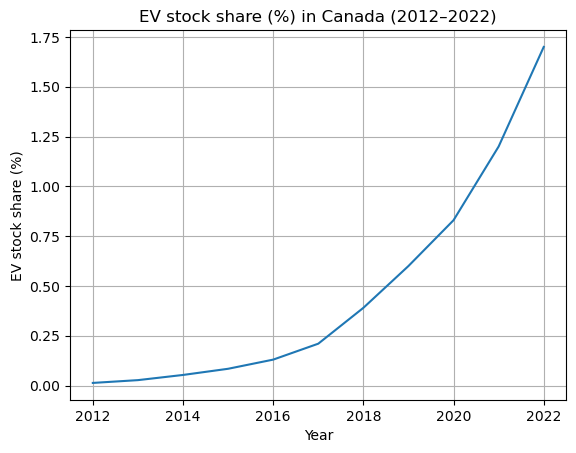

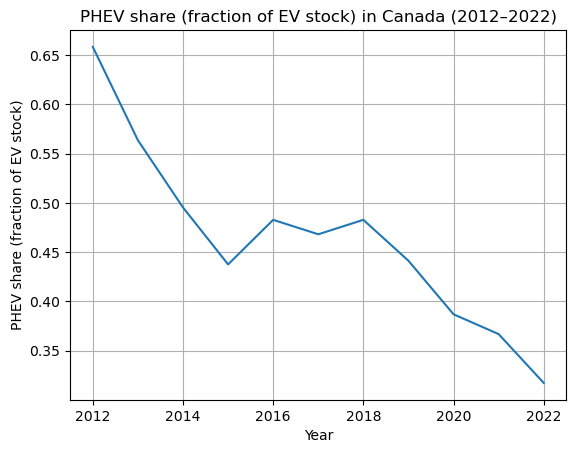

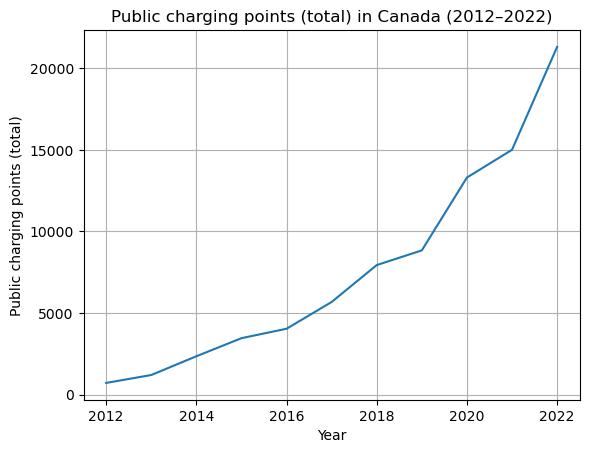

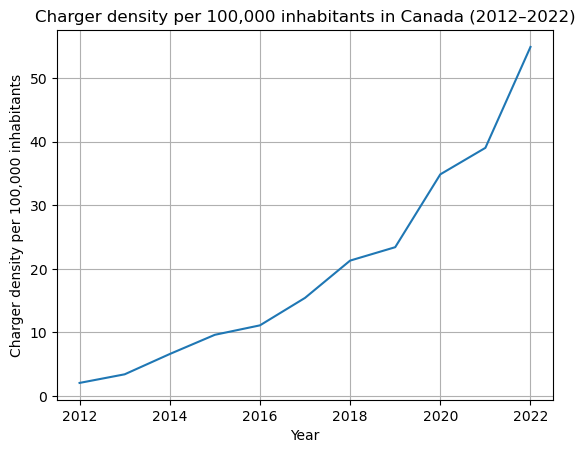

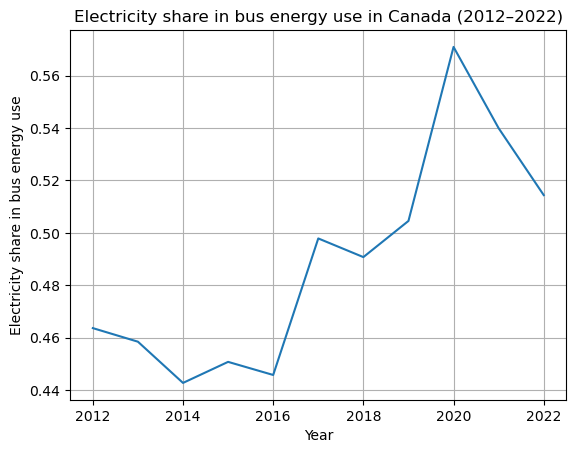

In [10]:
# === Chapter 3.1: Line plots using loops ===
# Loop-based generation of line charts for all key time series.

# Dictionary: column_name -> y-axis label
line_charts = {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)",
    "public_chargers_total": "Public charging points (total)",
    "charger_density_per_100k": "Charger density per 100,000 inhabitants",
    "electricity_share_bus": "Electricity share in bus energy use"
}

# Generate one chart per variable
for col, ylabel in line_charts.items():
    plt.figure()
    plt.plot(df_cleaned["year"], df_cleaned[col])
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} in Canada (2012–2022)")
    plt.grid(True)
    plt.show()


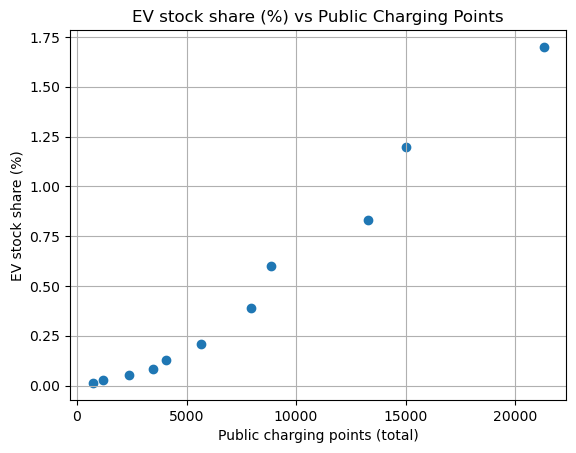

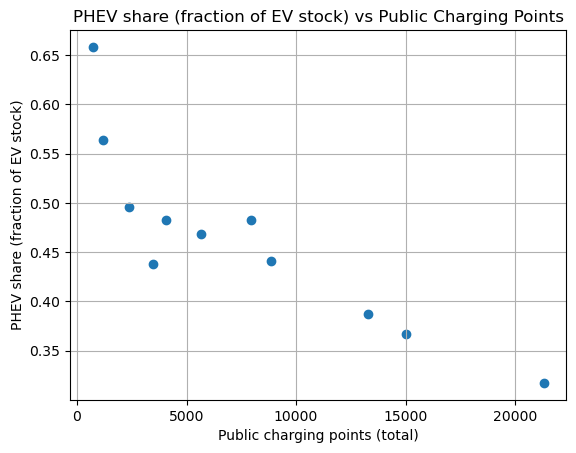

In [11]:
# === Chapter 3.2: Scatter plots using loops ===
# Generate scatter plots for infrastructure vs EV adoption.

scatter_pairs = {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)"
}

for target, ylabel in scatter_pairs.items():
    plt.figure()
    plt.scatter(df_cleaned["public_chargers_total"], df_cleaned[target])
    plt.xlabel("Public charging points (total)")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Public Charging Points")
    plt.grid(True)
    plt.show()


## Chapter 4. Spearman Correlation Analysis  
This chapter evaluates the monotonic association between EV adoption indicators  
and public charging infrastructure in Canada using the Spearman rank correlation.  
Spearman is selected because the variables are non-normal, monotonic, and follow  
exponential growth or decline trends, which violate Pearson assumptions.

In [12]:
# === Chapter 4.1: Spearman correlations for key hypothesis relationships ===
# Compute Spearman correlations between public charging points and EV adoption indicators.

correlation_pairs = {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)"
}

for col, label in correlation_pairs.items():
    coef, p_value = spearmanr(df_cleaned["public_chargers_total"], df_cleaned[col])
    print(f"\nSpearman correlation: Public chargers ↔ {label}")
    print(f"Correlation coefficient: {coef:.4f}")
    print(f"P-value: {p_value:.4f}")


Spearman correlation: Public chargers ↔ EV stock share (%)
Correlation coefficient: 1.0000
P-value: 0.0000

Spearman correlation: Public chargers ↔ PHEV share (fraction of EV stock)
Correlation coefficient: -0.8929
P-value: 0.0002


In [13]:
# === Chapter 4.2: Full Spearman correlation matrix ===
# Compute the Spearman correlation matrix for all numeric variables.

corr_matrix = df_cleaned.corr(method="spearman")
corr_matrix

,year,ev_stock_share,phev_share,public_chargers_fast,public_chargers_slow,public_chargers_total,population,internet_usage_pct,electricity_share_bus,charger_density_per_100k
year,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000
ev_stock_share,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000
phev_share,-0.892941,-0.892941,1.000000,-0.883562,-0.892941,-0.892941,-0.892941,-0.683373,-0.692485,-0.892941
public_chargers_fast,0.997725,0.997725,-0.883562,1.000000,0.997725,0.997725,0.997725,0.888385,0.792713,0.997725
public_chargers_slow,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000
public_chargers_total,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000
population,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000
internet_usage_pct,0.863636,0.863636,-0.683373,0.888385,0.863636,0.863636,0.863636,1.000000,0.627273,0.863636
electricity_share_bus,0.800000,0.800000,-0.692485,0.792713,0.800000,0.800000,0.800000,0.627273,1.000000,0.800000
charger_density_per_100k,1.000000,1.000000,-0.892941,0.997725,1.000000,1.000000,1.000000,0.863636,0.800000,1.000000


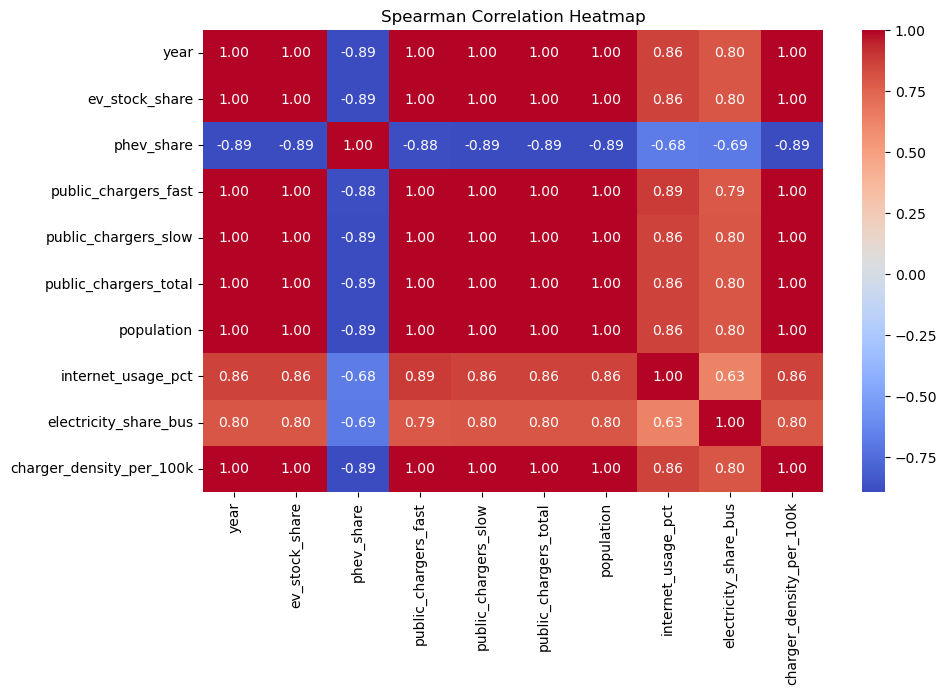

In [14]:
# === Chapter 4.3: Optional Spearman heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.show()


## Chapter 5. Robust Regression and Trend Analysis  
This chapter applies Theil–Sen regression to estimate robust trends between public charging infrastructure and EV adoption indicators.  
LOESS smoothing is used to visualize potential non-linear relationships without imposing a strict functional form.


Theil–Sen regression: EV stock share (%) vs Public charging points
Slope estimate: 0.000079
Intercept: -0.240794
95% CI for slope: [0.000052, 0.000091]


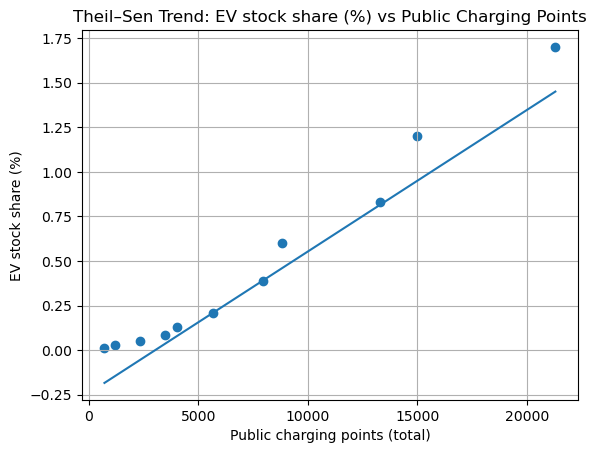


Theil–Sen regression: PHEV share (fraction of EV stock) vs Public charging points
Slope estimate: -0.000011
Intercept: 0.529894
95% CI for slope: [-0.000020, -0.000009]


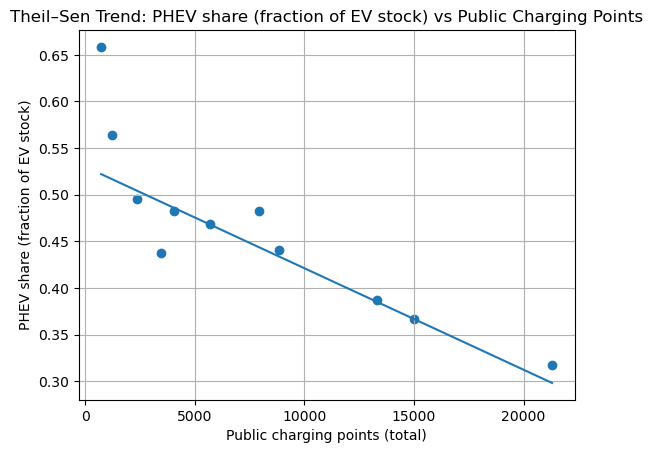

In [15]:
# === Chapter 5.1: Theil–Sen regression for EV adoption vs public chargers ===
# Theil–Sen provides a robust linear trend estimator that is less sensitive to non-normality and outliers.

# Dictionary: dependent variable -> label for printing and plotting
targets = {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)"
}

x = df_cleaned["public_chargers_total"].values  # independent variable

theil_results = {}  # store results for potential later use

for col, label in targets.items():
    y = df_cleaned[col].values
    
    # Compute Theil–Sen estimator
    slope, intercept, lo_slope, up_slope = theilslopes(y, x, alpha=0.95)
    theil_results[col] = {
        "slope": slope,
        "intercept": intercept,
        "lo_slope": lo_slope,
        "up_slope": up_slope
    }
    
    # Print numeric summary
    print(f"\nTheil–Sen regression: {label} vs Public charging points")
    print(f"Slope estimate: {slope:.6f}")
    print(f"Intercept: {intercept:.6f}")
    print(f"95% CI for slope: [{lo_slope:.6f}, {up_slope:.6f}]")
    
    # Generate fitted line for plotting
    x_sorted = np.sort(x)
    y_fitted = intercept + slope * x_sorted
    
    # Scatter + Theil–Sen line
    plt.figure()
    plt.scatter(x, y)
    plt.plot(x_sorted, y_fitted)
    plt.xlabel("Public charging points (total)")
    plt.ylabel(label)
    plt.title(f"Theil–Sen Trend: {label} vs Public Charging Points")
    plt.grid(True)
    plt.show()

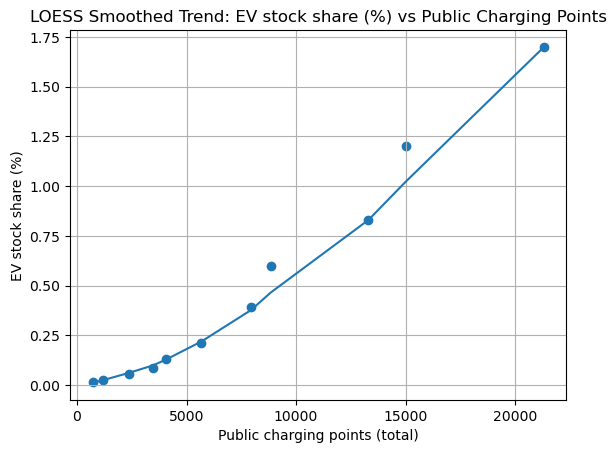

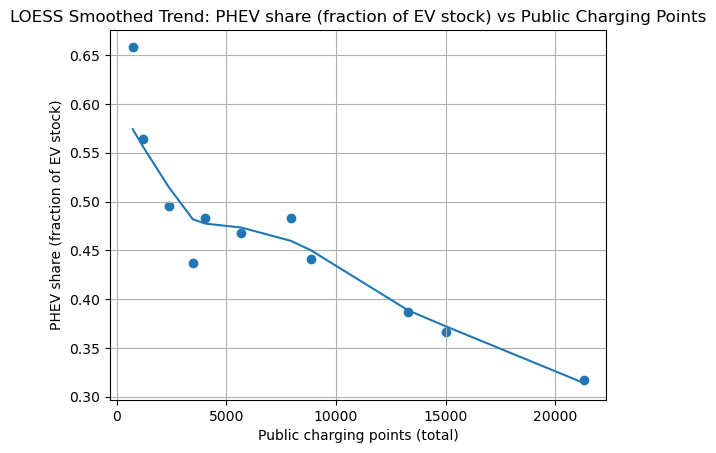

In [16]:
# === Chapter 5.2: LOESS smoothing for non-linear trend visualization ===
# LOESS is used here to visualize potential non-linear relationships between chargers and EV adoption.

# Parameter controlling the amount of smoothing (0 < frac <= 1)
frac_value = 0.6  # higher values produce smoother curves

for col, label in targets.items():
    y = df_cleaned[col].values
    
    # Compute LOESS smoothed values
    loess_result = lowess(
        y, 
        x,
        frac=frac_value,
        return_sorted=True
    )
    
    x_loess = loess_result[:, 0]
    y_loess = loess_result[:, 1]
    
    # Scatter + LOESS curve
    plt.figure()
    plt.scatter(x, y)
    plt.plot(x_loess, y_loess)
    plt.xlabel("Public charging points (total)")
    plt.ylabel(label)
    plt.title(f"LOESS Smoothed Trend: {label} vs Public Charging Points")
    plt.grid(True)
    plt.show()

## Chapter 6. Residual Diagnostics for Theil–Sen Models  
This chapter computes residuals for the Theil–Sen regression models and  
visualizes them against fitted values and public charging points.  
These plots are used only as descriptive tools, since Theil–Sen does not rely  
on classical OLS assumptions about residuals.

In [17]:
# === Chapter 6.1: Compute residuals for Theil–Sen models ===
# Residuals are used here only for descriptive visual assessment.

residuals_dict = {}  # store residuals and fitted values

x = df_cleaned["public_chargers_total"].values  # independent variable

for col, label in {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)"
}.items():
    
    y = df_cleaned[col].values
    
    # Retrieve Theil–Sen slope and intercept from previous results
    slope = theil_results[col]["slope"]
    intercept = theil_results[col]["intercept"]
    
    # Compute fitted values and residuals
    y_fitted = intercept + slope * x
    residuals = y - y_fitted
    
    residuals_dict[col] = {
        "label": label,
        "y": y,
        "y_fitted": y_fitted,
        "residuals": residuals
    }

    # Print quick summary
    print(f"\nResiduals summary for {label}:")
    print(f"Mean residual: {residuals.mean():.6f}")
    print(f"Min residual: {residuals.min():.6f}")
    print(f"Max residual: {residuals.max():.6f}")


Residuals summary for EV stock share (%):
Mean residual: 0.111928
Min residual: 0.000000
Max residual: 0.250317

Residuals summary for PHEV share (fraction of EV stock):
Mean residual: 0.016708
Min residual: -0.054710
Max residual: 0.136399


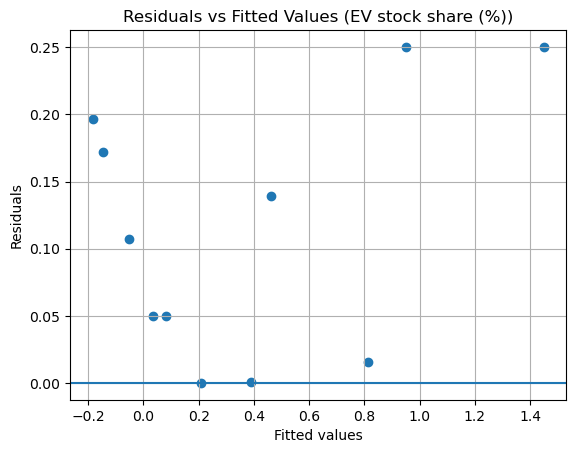

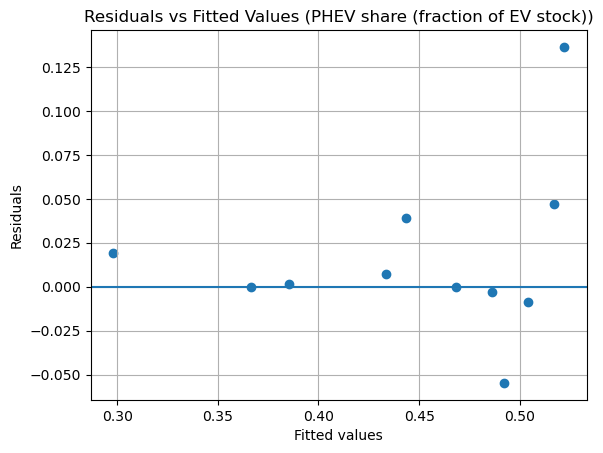

In [18]:
# === Chapter 6.2: Residuals vs fitted values with horizontal zero line ===
# Descriptive plots to check general pattern of residuals.

for col, content in residuals_dict.items():
    label = content["label"]
    y_fitted = content["y_fitted"]
    residuals = content["residuals"]
    
    plt.figure()
    plt.scatter(y_fitted, residuals)
    plt.axhline(0.0)  # horizontal line at zero residual
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted Values ({label})")
    plt.grid(True)
    plt.show()

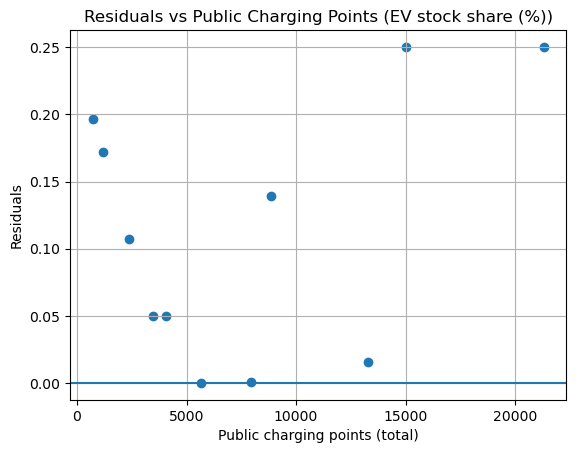

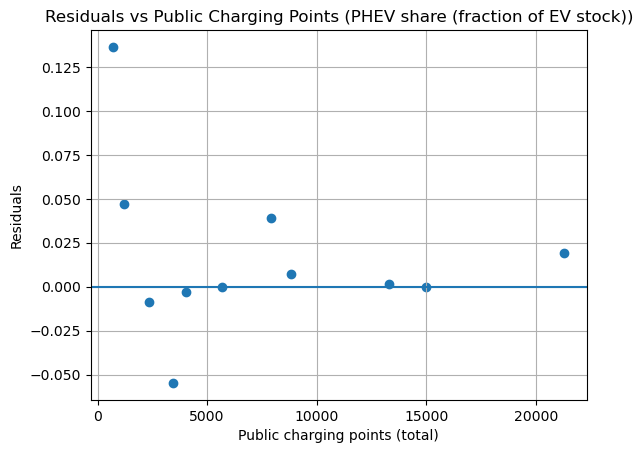

In [19]:
# === Chapter 6.3: Residuals vs public charging points with horizontal zero line ===
# Descriptive plots to check if residuals show any pattern with the predictor.

x = df_cleaned["public_chargers_total"].values  # independent variable

for col, content in residuals_dict.items():
    label = content["label"]
    residuals = content["residuals"]
    
    plt.figure()
    plt.scatter(x, residuals)
    plt.axhline(0.0)  # horizontal line at zero residual
    plt.xlabel("Public charging points (total)")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Public Charging Points ({label})")
    plt.grid(True)
    plt.show()

## Chapter 7: Forecasting preparation  

This chapter develops short-term forecasts for EV stock share and PHEV share using two 
complementary approaches. The first method applies time-based Theil–Sen regression to extend 
the robust linear trend identified in the historical data, generating stable projections for 
the 2023–2026 horizon. The second method uses LOESS smoothing to capture the non-linear 
structure of the adoption curves and produce an exploratory extension of the most recent 
local trend. These forecasting techniques provide forward-looking insights into the 
expected trajectory of technological adoption under continued infrastructure expansion.


In [20]:
# === Chapter 7.1: Prepare forecast horizon ===
# Define future years for forecasting.

year_hist = df_cleaned["year"].values
start_year = year_hist.min()
end_year_hist = year_hist.max()

# Forecast horizon: 2023–2026 (4 future years)
forecast_years = np.arange(end_year_hist + 1, end_year_hist + 5)

print("Historical years:", year_hist)
print("Forecast years:", forecast_years)


Historical years: [2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012]
Forecast years: [2023 2024 2025 2026]



Theil–Sen time-based trend for EV stock share (%):
Slope: 0.131889 per year
Intercept: -265.809889
95% CI for slope: [0.063000, 0.210000]


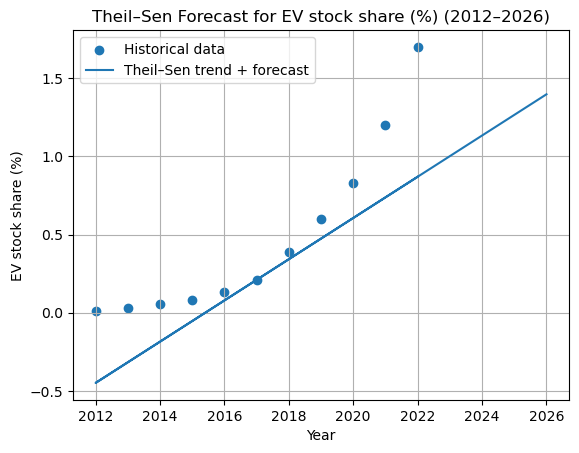


Theil–Sen time-based trend for PHEV share (fraction of EV stock):
Slope: -0.025355 per year
Intercept: 51.608333
95% CI for slope: [-0.038070, -0.014674]


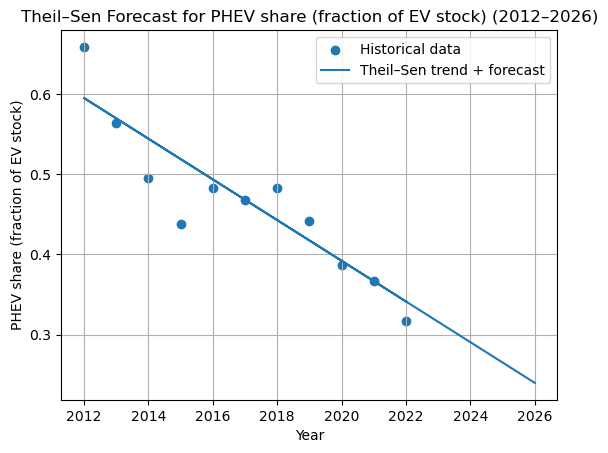

In [21]:
# === Chapter 7.2: Compute Theil–Sen predictions (2012–2026) ===
# Use YEAR as the independent variable to estimate robust linear trends and forecast 4 future years.

targets_time = {
    "ev_stock_share": "EV stock share (%)",
    "phev_share": "PHEV share (fraction of EV stock)"
}

theil_time_results = {}
forecast_records = []

x_time = year_hist  # independent variable for forecasting (year)

for col, label in targets_time.items():
    y = df_cleaned[col].values
    
    # Theil–Sen estimator with year as predictor
    slope, intercept, lo_slope, up_slope = theilslopes(y, x_time, alpha=0.95)
    theil_time_results[col] = {
        "slope": slope,
        "intercept": intercept,
        "lo_slope": lo_slope,
        "up_slope": up_slope
    }
    
    print(f"\nTheil–Sen time-based trend for {label}:")
    print(f"Slope: {slope:.6f} per year")
    print(f"Intercept: {intercept:.6f}")
    print(f"95% CI for slope: [{lo_slope:.6f}, {up_slope:.6f}]")
    
    # Historical fitted values
    y_fitted_hist = intercept + slope * x_time
    
    # Forecast for 2023–2026
    y_forecast = intercept + slope * forecast_years
    
    # Store for table creation
    for year, pred in zip(forecast_years, y_forecast):
        forecast_records.append({
            "variable": col,
            "label": label,
            "year": int(year),
            "prediction_theil_sen": pred
        })
    
    # Plot historical + forecast line
    all_years = np.concatenate([x_time, forecast_years])
    all_pred = intercept + slope * all_years
    
    import matplotlib.pyplot as plt
    plt.figure()
    plt.scatter(x_time, y, label="Historical data")
    plt.plot(all_years, all_pred, label="Theil–Sen trend + forecast")
    plt.xlabel("Year")
    plt.ylabel(label)
    plt.title(f"Theil–Sen Forecast for {label} (2012–2026)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [22]:
# === Chapter 7.3: Build forecast table (Theil–Sen) ===
# Convert forecast records into a DataFrame for easier inspection and export.

df_forecast_theil = pd.DataFrame(forecast_records)
df_forecast_theil = df_forecast_theil.sort_values(by=["variable", "year"]).reset_index(drop=True)

print("Theil–Sen forecast table (time-based):")
display(df_forecast_theil)


Theil–Sen forecast table (time-based):


,variable,label,year,prediction_theil_sen
0,ev_stock_share,EV stock share (%),2023,1.001333
1,ev_stock_share,EV stock share (%),2024,1.133222
2,ev_stock_share,EV stock share (%),2025,1.265111
3,ev_stock_share,EV stock share (%),2026,1.397000
4,phev_share,PHEV share (fraction of EV stock),2023,0.315957
5,phev_share,PHEV share (fraction of EV stock),2024,0.290603
6,phev_share,PHEV share (fraction of EV stock),2025,0.265248
7,phev_share,PHEV share (fraction of EV stock),2026,0.239894


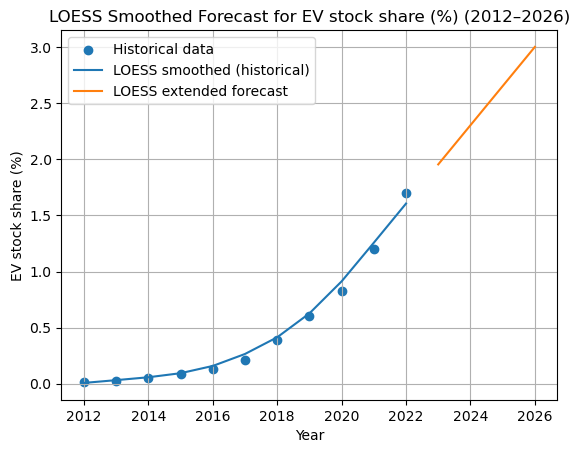

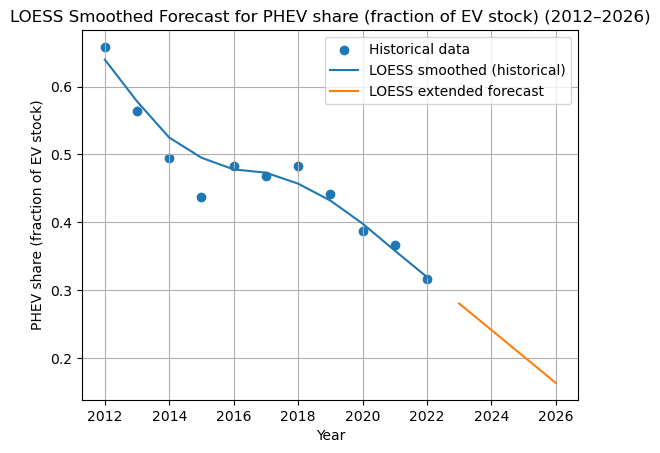

In [23]:
# === Chapter 7.3.1 & 7.3.2: Fit LOESS on historical data and extend trend ===
# LOESS is used to capture non-linear behavior; the forecast is exploratory and based on extending
# the last local trend segment.

loess_forecast_records = []

frac_value = 0.6  # smoothing parameter

for col, label in targets_time.items():
    y = df_cleaned[col].values
    
    # Fit LOESS on historical data (year vs target)
    loess_result = lowess(
        y,
        x_time,
        frac=frac_value,
        return_sorted=True
    )
    
    x_loess_hist = loess_result[:, 0]
    y_loess_hist = loess_result[:, 1]
    
    # Estimate last local slope based on the last two smoothed points
    last_slope = y_loess_hist[-1] - y_loess_hist[-2]
    
    # Build LOESS-based exploratory forecast by linearly extending the last smoothed point
    y_loess_forecast = []
    last_value = y_loess_hist[-1]
    
    for k, year in enumerate(forecast_years, start=1):
        next_value = last_value + k * last_slope
        y_loess_forecast.append(next_value)
        loess_forecast_records.append({
            "variable": col,
            "label": label,
            "year": int(year),
            "prediction_loess_ext": next_value
        })
    
    # Plot historical LOESS fit + extended forecast
    all_years_loess = np.concatenate([x_loess_hist, forecast_years])
    all_values_loess = np.concatenate([y_loess_hist, np.array(y_loess_forecast)])
    
    plt.figure()
    plt.scatter(x_time, y, label="Historical data")
    plt.plot(x_loess_hist, y_loess_hist, label="LOESS smoothed (historical)")
    plt.plot(forecast_years, y_loess_forecast, label="LOESS extended forecast")
    plt.xlabel("Year")
    plt.ylabel(label)
    plt.title(f"LOESS Smoothed Forecast for {label} (2012–2026)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [24]:
# === Chapter 7.3.3: Build LOESS forecast table ===
df_forecast_loess = pd.DataFrame(loess_forecast_records)
df_forecast_loess = df_forecast_loess.sort_values(by=["variable", "year"]).reset_index(drop=True)

print("LOESS-based exploratory forecast table:")
display(df_forecast_loess)


LOESS-based exploratory forecast table:


,variable,label,year,prediction_loess_ext
0,ev_stock_share,EV stock share (%),2023,1.954363
1,ev_stock_share,EV stock share (%),2024,2.303263
2,ev_stock_share,EV stock share (%),2025,2.652163
3,ev_stock_share,EV stock share (%),2026,3.001063
4,phev_share,PHEV share (fraction of EV stock),2023,0.280303
5,phev_share,PHEV share (fraction of EV stock),2024,0.241286
6,phev_share,PHEV share (fraction of EV stock),2025,0.202268
7,phev_share,PHEV share (fraction of EV stock),2026,0.163251
